In [31]:
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html 
# Install required libraries
# Import required libraries
import random
import math
import gymnasium as gym
from gymnasium import spaces
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
from itertools import count

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"
)

print(device)

cuda


In [32]:
# imports are always needed
import torch


# get index of currently selected device
torch.cuda.current_device() # returns 0 in my case


# get number of GPUs available
torch.cuda.device_count() # returns 1 in my case


# get the name of the device
torch.cuda.get_device_name(0) # good old Tesla K80


'NVIDIA GeForce RTX 4070 Laptop GPU'

In [80]:
#create environment to run DQN


env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()
episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

# modify this to fit current environment 
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

In [34]:
class DQN(nn.Module):

    def __init__(self, obs, action):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(obs, 32)
        self.layer2 = nn.Linear(32, 32)
        self.layer3 = nn.Linear(32, action)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [84]:
class agent():
    def __init__(self,obs,actions):
        self.batch = 128
        self.discount_factor = 0.99
        self.eps = 1
        self.eps_decay = 0.9954
        # self.tau = 0.005
        self.learning_rate = 0.1
        self.memory = ReplayMemory(5000) # replay memory 
        self.policy_net = DQN(obs, actions).to(device) # action value function
        self.target_net = DQN(obs, actions).to(device) # target action value function 
    
    def select_action(self,state):
        p = random.random()
        if p < self.eps:
            #random action
            return
        else:
            #best action
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                return self.policy_net(state).max(1).indices.view(1, 1)
    def update(self,timestep,episode,terminated):
        #update weight every 5 steps
        if timestep%5 == 0:
            #sample and train 
            self.replay()
        #update target_net every 5 eps, If solved, set as target_net
        if episode%5 == 0 or terminated == True:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        return self.target_net, self.policy_net
    
    def replay(self):
        if len(self.memory) < self.batch:
            return
        else:
            sample = self.memory.sample(self.batch)
        #replay algorithim here
        
             
            
        
    

In [90]:

actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
obs = len(state)
# agent = agent(obs,actions)
torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
m = deque([], maxlen=5)
m.append(1)
len(m)

1

In [ ]:
#create environment to run DQN
env = gym.make("CartPole-v1")

max_episodes = 600
state, info = env.reset()
obs = len(state)
agent = agent(obs,actions)

for episode in range(max_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = agent.select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        agent.memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        # optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        agent.update(episode)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [35]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1
EPS_END = 0.001
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
obs = len(state)

policy_net = DQN(obs, actions).to(device)
target_net = DQN(obs, actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(5000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)



In [36]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


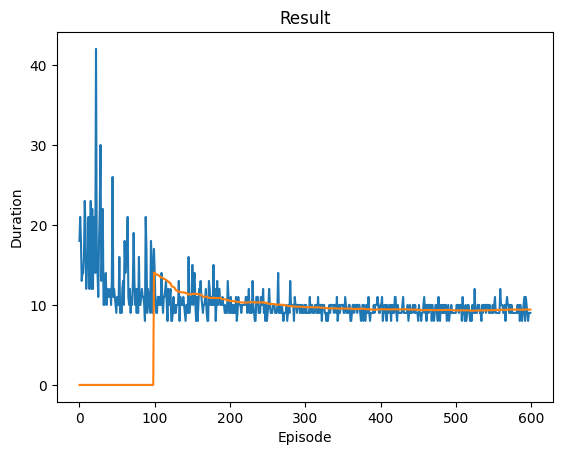

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [37]:
max_episodes = 600


for i in range(max_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [38]:
print(target_net_state_dict)


OrderedDict({'layer1.weight': tensor([[ 0.4686, -0.1814, -0.3235, -0.7056],
        [-0.5390, -0.2514,  0.6905, -0.1037],
        [-0.0360, -0.0858,  0.3350, -0.2154],
        [ 0.1116, -0.0621,  0.5750,  0.1373],
        [ 0.2370, -0.1658,  0.2071,  0.3728],
        [-0.5993, -0.1364,  0.1335,  0.5679],
        [-0.1174,  0.2411, -0.2316, -0.6071],
        [-0.5002,  0.6282,  0.0227, -0.6031],
        [-0.3577,  0.4537, -0.0204,  0.1239],
        [-0.1786,  0.0645,  0.3548,  0.1523],
        [-0.2807, -0.2263,  0.1350, -0.0335],
        [-0.0519, -0.0628,  0.1688,  0.0839],
        [-0.6874,  0.0945,  0.7361,  0.7120],
        [-0.5373,  0.2515,  0.5639,  0.1018],
        [-0.6425,  0.4219,  0.0454,  0.4431],
        [-0.1559, -0.2558,  0.0349, -0.1726],
        [ 0.4615, -0.4487,  0.1459, -0.2408],
        [ 0.8709,  0.2113, -0.3485, -0.7267],
        [-0.0489, -0.1189,  0.2304, -0.1968],
        [ 0.1530,  0.0306,  0.6941,  0.2780],
        [-0.2134,  0.2761, -0.1358,  0.0785],
    

In [39]:
print(policy_net_state_dict)

OrderedDict({'layer1.weight': tensor([[ 0.4767, -0.1784, -0.3349, -0.7096],
        [-0.5371, -0.2502,  0.6897, -0.1048],
        [-0.0322, -0.0837,  0.3314, -0.2176],
        [ 0.1134, -0.0609,  0.5741,  0.1361],
        [ 0.2442, -0.1660,  0.1972,  0.3718],
        [-0.6133, -0.1413,  0.1511,  0.5743],
        [-0.1085,  0.2440, -0.2439, -0.6113],
        [-0.4898,  0.6319,  0.0092, -0.6082],
        [-0.3547,  0.4552, -0.0227,  0.1222],
        [-0.1766,  0.0658,  0.3538,  0.1509],
        [-0.2781, -0.2248,  0.1332, -0.0350],
        [-0.0496, -0.0614,  0.1673,  0.0824],
        [-0.6996,  0.0898,  0.7513,  0.7178],
        [-0.5348,  0.2530,  0.5623,  0.1002],
        [-0.6397,  0.4236,  0.0434,  0.4412],
        [-0.1559, -0.2557,  0.0349, -0.1726],
        [ 0.4614, -0.4487,  0.1459, -0.2408],
        [ 0.8782,  0.2140, -0.3588, -0.7304],
        [-0.0461, -0.1173,  0.2283, -0.1985],
        [ 0.1545,  0.0317,  0.6936,  0.2769],
        [-0.2097,  0.2780, -0.1389,  0.0763],
    